In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Exploring train data

1. **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
3. **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. **Destination** - The planet the passenger will be debarking to.
6. **Age** - The age of the passenger.
7. **VIP** - Whether the passenger has paid for special VIP service during the voyage.
8. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. **Name** - The first and last names of the passenger.

10. **Transported** - Whether the passenger was transported to another dimension. **This is the target to predict.**

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train_df.shape

(8693, 14)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train_df = train_df.dropna()
train_df = train_df.reset_index(drop=True)
train_df.shape

(6606, 14)

In [6]:
train_target_sr = train_df.Transported
train_df = train_df.drop('Transported', axis=1)
train_target_sr.value_counts()

True     3327
False    3279
Name: Transported, dtype: int64

## Feature engineering

In [7]:
# TODO: consider making detailed EDA for correlations between deck and socieconomic status (VIP, billing etc)
train_df[['Cabin_deck', 'Cabin_num', 'Cabin_side']] = train_df['Cabin'].str.split(pat='/', n=2, expand=True)
train_df['Cabin_num'] = train_df['Cabin_num'].astype(int)
train_df = train_df.drop(['Cabin'], axis=1)

In [8]:
# TODO: consider doing this before dropna.
train_df[['PassengerId_g', 'PassengerId_p']] = train_df['PassengerId'].str.split(pat='_', n=1, expand=True)
train_df['PassengerId_p'] = train_df['PassengerId_p'].astype(int)
train_df['GroupSize'] = train_df.apply(lambda row: train_df[train_df['PassengerId_g'] == row.PassengerId_g].PassengerId_p.max(), axis=1)
train_df = train_df.drop(['PassengerId', 'PassengerId_g', 'PassengerId_p'], axis=1)

In [9]:
train_df = train_df.replace({'TRAPPIST-1e': 'Trappist', '55 Cancri e': 'Cancri', 'PSO J318.5-22': 'Pso'})

In [10]:
train_df[['Name_first', 'Name_last']] = train_df['Name'].str.split(pat=' ', n=2, expand=True)
train_df = train_df.drop(['Name'], axis=1)

In [11]:
# TODO: consider droping first in get_dummies
train_df = pd.get_dummies(train_df, columns=['HomePlanet', 'Cabin_deck', 'Cabin_side', 'VIP', 'CryoSleep', 'Destination'])
train_df['Transported'] = train_target_sr
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6606 entries, 0 to 6605
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   6606 non-null   float64
 1   RoomService           6606 non-null   float64
 2   FoodCourt             6606 non-null   float64
 3   ShoppingMall          6606 non-null   float64
 4   Spa                   6606 non-null   float64
 5   VRDeck                6606 non-null   float64
 6   Cabin_num             6606 non-null   int32  
 7   GroupSize             6606 non-null   int32  
 8   Name_first            6606 non-null   object 
 9   Name_last             6606 non-null   object 
 10  HomePlanet_Earth      6606 non-null   uint8  
 11  HomePlanet_Europa     6606 non-null   uint8  
 12  HomePlanet_Mars       6606 non-null   uint8  
 13  Cabin_deck_A          6606 non-null   uint8  
 14  Cabin_deck_B          6606 non-null   uint8  
 15  Cabin_deck_C         

In [12]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,GroupSize,HomePlanet_Earth,HomePlanet_Europa,...,Cabin_deck_T,Cabin_side_P,Cabin_side_S,VIP_False,VIP_True,CryoSleep_False,CryoSleep_True,Destination_Cancri,Destination_Pso,Destination_Trappist
count,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,...,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000
mean,28.894036,222.991674,478.958523,178.356494,313.161520,303.780048,599.177414,1.953981,0.539812,0.253255,...,0.000303,0.493642,0.506358,0.975477,0.024523,0.646988,0.353012,0.212988,0.094308,0.692704
std,14.533429,644.987936,1678.592291,576.328407,1144.016291,1127.142166,513.450585,1.532786,0.498450,0.434908,...,0.017399,0.499997,0.499997,0.154678,0.154678,0.477943,0.477943,0.409450,0.292279,0.461408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,166.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,424.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,49.000000,82.750000,30.000000,65.000000,52.000000,994.000000,2.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,79.000000,9920.000000,29813.000000,12253.000000,22408.000000,20336.000000,1894.000000,8.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


CPU times: total: 12.3 s
Wall time: 12.4 s


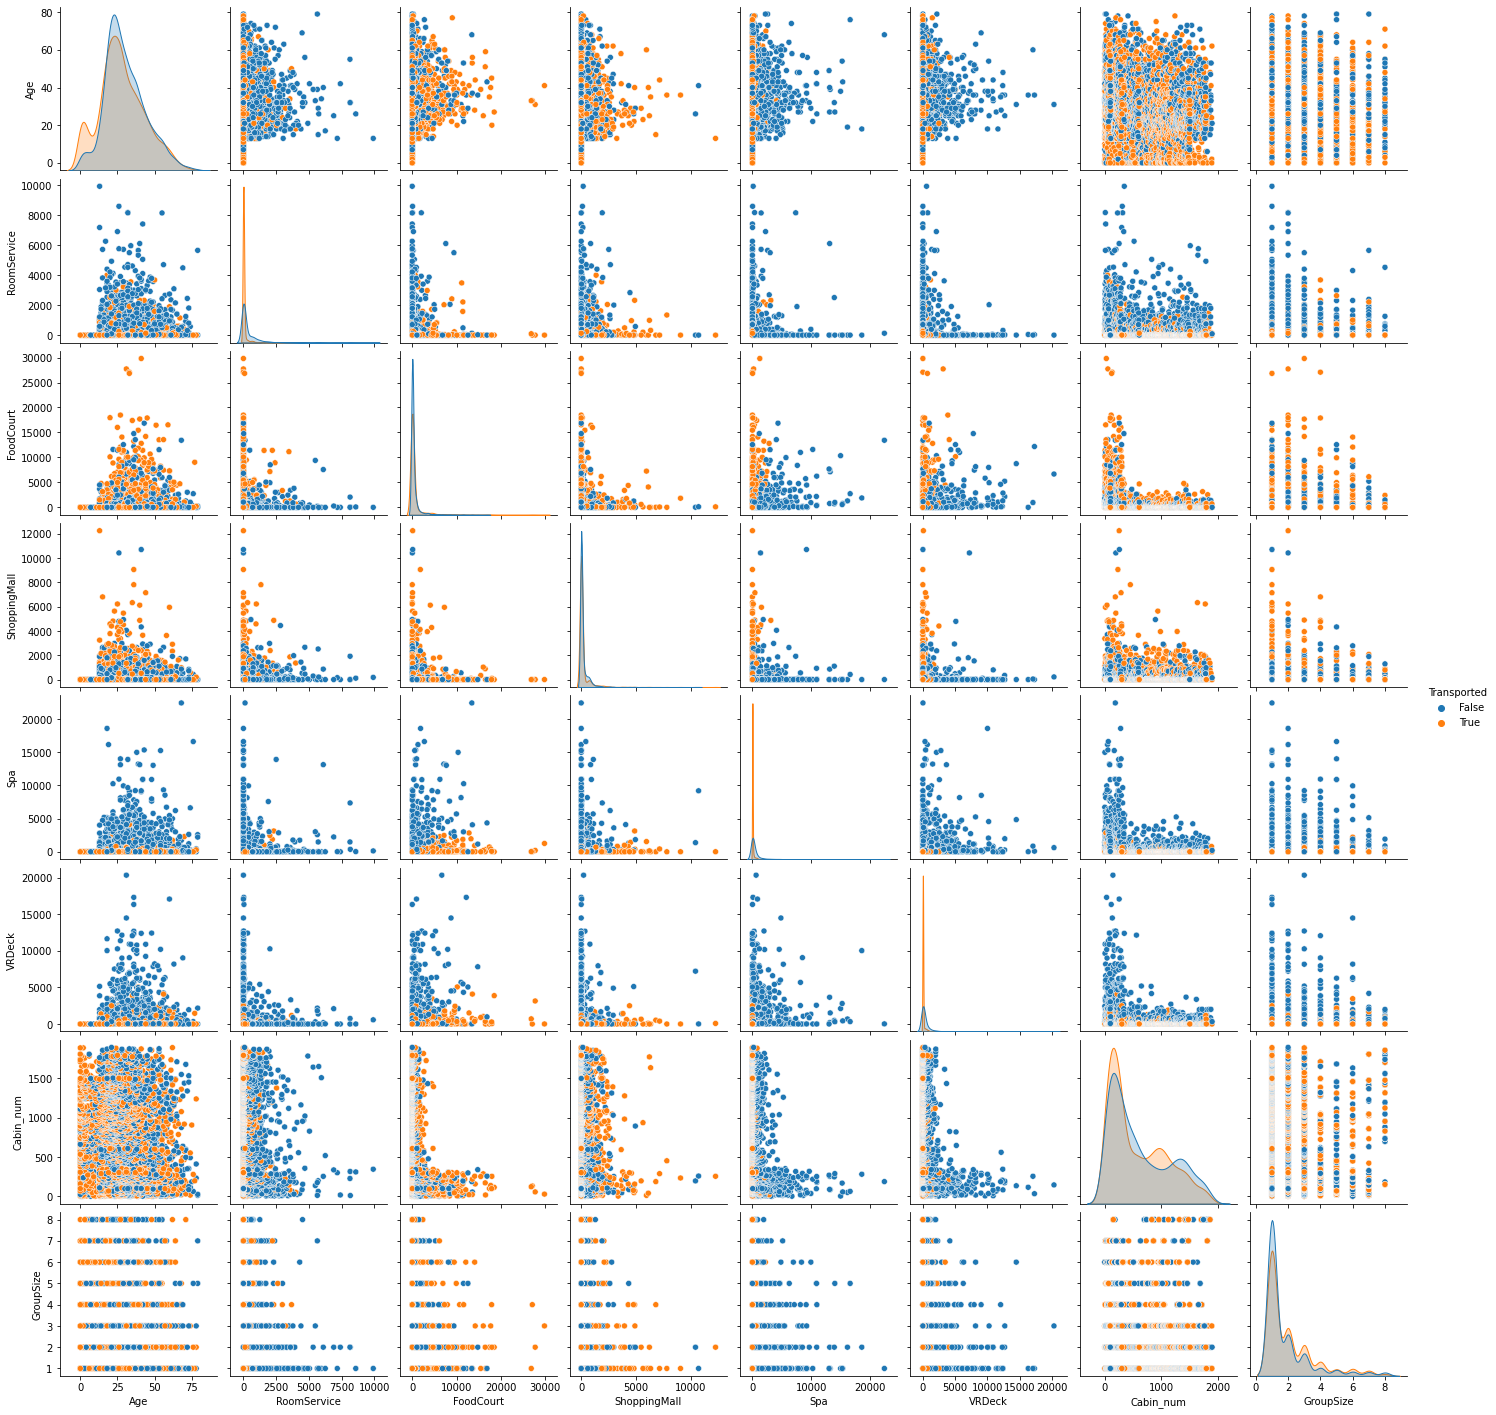

In [13]:
%%time
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_num', 'GroupSize']
sns.pairplot(train_df[numerical_columns + ['Transported']], kind="scatter", hue="Transported");

CPU times: total: 344 ms
Wall time: 346 ms


<AxesSubplot:>

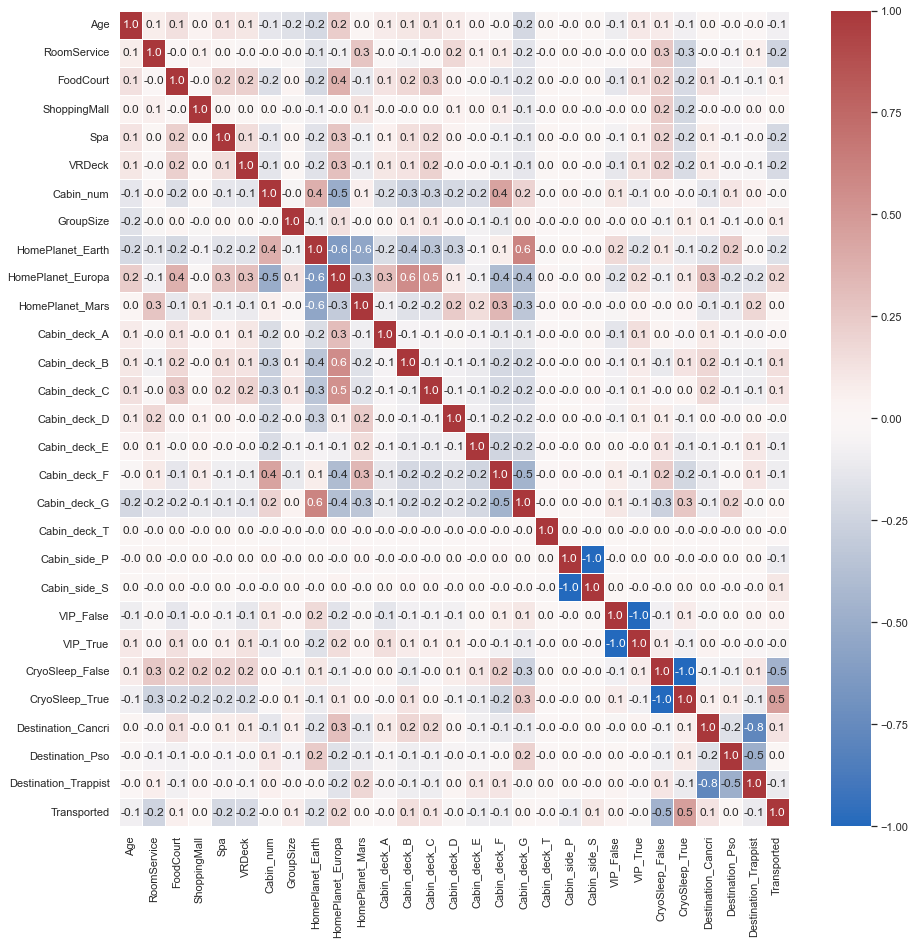

In [14]:
%%time
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(train_df.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, linewidths=.5, fmt='.1f');